In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

2024-12-13 11:47:13.940876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 11:47:14.616315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load dataset
data = pd.read_csv("stock_data.csv")
data

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [3]:
# Preprocess dataset
data['Sentiment'] = data['Sentiment'].apply(lambda x: 1 if x == 1 else 0)
texts = data['Text'].values
sentiments = data['Sentiment'].values

In [4]:
texts

array(['Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts',
       'user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year.  AWESOME.  ',
       "user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service",
       ...,
       'Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd',
       '#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI',
       "#Sensex, #Nifty climb off day's highs, still up 2%; Key factors driving D-Street higher today https://t.co/jVQcousFp6"],
      dtype=object)

In [5]:
sentiments

array([1, 1, 1, ..., 1, 1, 1])

In [6]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and pad/truncate the data
def tokenize_data(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        # Ensure all sequences are of max_len
        padding='max_length',  
        max_length=max_len,
        return_tensors='tf'
    )
    return encodings

max_len = 128
encodings = tokenize_data(texts, tokenizer, max_len=max_len)

2024-12-13 11:47:20.327298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11541 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2024-12-13 11:47:20.327939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11541 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2024-12-13 11:47:20.328458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11541 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2024-12-13 11:47:20.328957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11533 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, comp

In [7]:
# Convert to NumPy arrays
input_ids_np = encodings['input_ids'].numpy()
attention_mask_np = encodings['attention_mask'].numpy()

# Split dataset
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids_np, sentiments, test_size=0.2, random_state=42
)

train_attention, test_attention = train_test_split(
    attention_mask_np, test_size=0.2, random_state=42
)

print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train attention shape: {train_attention.shape}")

Train inputs shape: (4632, 128)
Train attention shape: (4632, 128)


In [8]:
# BERT Model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define the model
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_output.last_hidden_state

bert_model.trainable = True  

# Freeze the pooler layer
for layer in bert_model.layers:
    if 'pooler' in layer.name:
        layer.trainable = False

# CNN layers
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(sequence_output)
pool2 = GlobalMaxPooling1D()(conv1)

# Fully connected layer
fc1 = Dense(128, activation='relu')(pool2)
fc2 = Dense(32, activation='relu')(fc1)
dropout1 = Dropout(0.3)(fc2)
output = Dense(1, activation='relu')(dropout1)

# Compile model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [10]:
# Model Checkpoint
checkpoint_callback = ModelCheckpoint(
    'bert_cnn_sentiment_model_2layers.h5',         
    monitor='accuracy',      
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

# Training
history = model.fit(
    [train_inputs, train_attention],
    train_labels,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_callback]
)


Epoch 1/100


2024-12-13 11:47:39.840467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-12-13 11:47:39.996978: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xc9843d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-13 11:47:39.997023: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2024-12-13 11:47:39.997039: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2024-12-13 11:47:39.997051: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA TITAN Xp, Compute Capability 6.1
2024-12-13 11:47:39.997062: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA TITAN Xp, Compute Capability 6.1
2024-12-13 11:47:40.004653: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling M

116/116 [==============================] - ETA: 0s - loss: 5.5349 - accuracy: 0.5107
Epoch 1: accuracy improved from -inf to 0.51066, saving model to bert_cnn_sentiment_model_2layers.h5


/home/deeptimaan/.conda/envs/venv-p39-tf2/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 89s 521ms/step - loss: 5.5349 - accuracy: 0.5107 - val_loss: 3.6224 - val_accuracy: 0.6580
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 4.1814 - accuracy: 0.5358
Epoch 2: accuracy improved from 0.51066 to 0.53576, saving model to bert_cnn_sentiment_model_2layers.h5
116/116 [==============================] - 59s 510ms/step - loss: 4.1814 - accuracy: 0.5358 - val_loss: 1.5913 - val_accuracy: 0.6494
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 2.7272 - accuracy: 0.5560
Epoch 3: accuracy improved from 0.53576 to 0.55601, saving model to bert_cnn_sentiment_model_2layers.h5
116/116 [==============================] - 60s 514ms/step - loss: 2.7272 - accuracy: 0.5560 - val_loss: 0.9798 - val_accuracy: 0.6246
Epoch 4/100
116/116 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.5533
Epoch 4: accuracy did not improve from 0.55601
116/116 [==============================] - 54s 466ms

In [11]:
# Evaluation
loss, accuracy = model.evaluate([test_inputs, test_attention], test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


37/37 [==============================] - 6s 155ms/step - loss: 3.0837 - accuracy: 0.7679
Test Loss: 3.0836904048919678, Test Accuracy: 0.7679033875465393


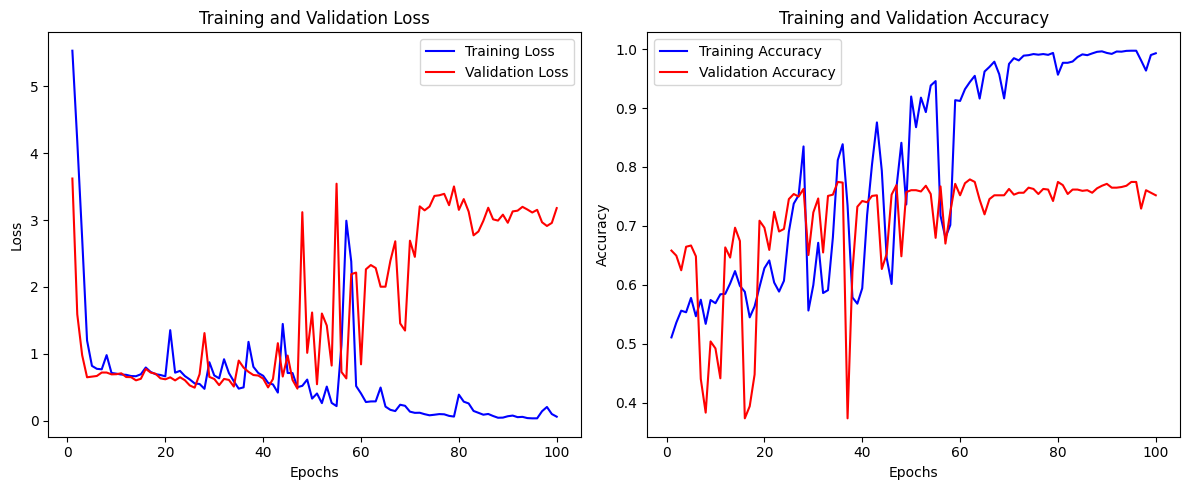

In [12]:
import matplotlib.pyplot as plt

# Extracting data from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Getting the number of epochs
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions
predictions = model.predict([test_inputs, test_attention])
predicted_labels = (predictions.flatten() > 0.5).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(test_labels, predicted_labels, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(class_report)


37/37 [==============================] - 8s 161ms/step
Confusion Matrix:
[[296 131]
 [138 594]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.69      0.69       427
    Positive       0.82      0.81      0.82       732

    accuracy                           0.77      1159
   macro avg       0.75      0.75      0.75      1159
weighted avg       0.77      0.77      0.77      1159

